In [1]:
cd /home/chenxupeng/projects/deepshape/

/home/chenxupeng/projects/deepshape


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import argparse, sys, os, errno
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import keras as K
import seaborn as sns
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from unet_128_model_row_column import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
%pylab inline
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.99
set_session(tf.Session(config=config))
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [3]:
#540条
ic_shape = {}
with h5py.File('known/known.h5') as f:
    for i in tqdm(range(540)):
        ic_shape[i] = f['known'][f['start'][i]:f['end'][i]]
    icshape = np.array([value for (key,value) in ic_shape.iteritems()])
    name = f['name'][:]

100%|██████████| 540/540 [00:00<00:00, 1400.13it/s]


In [4]:
model_path = 'output/newunet_row_col_mse_1.31_pick.hdf5'
def Model(model_path):
    #为转成十六通道的图片预测shape做准备
    model = UNET_128()
    optim = Adam()
    model.compile(optimizer=optim, loss=CrossEntropyLoss(model,10), metrics=[binary_accuracy_with_nan,binary_crossentropy_with_nan,MSE(model)])
    loss=CrossEntropyLoss(model,10)
    model = load_model(model_path,custom_objects = {"CrossEntropyLoss": loss,\
                                                                            'binary_accuracy_with_nan':binary_accuracy_with_nan,\
                                                                            'binary_crossentropy_with_nan':binary_crossentropy_with_nan,\
                                                                            'MSE':MSE(model)})
    return model
model = Model(model_path)

In [7]:
save_path = 'acc_1.31_pick_1'

In [8]:
def calculate_acc(array,true_score):
    '''
    an array of shape (length)*128
    对齐并且求中间每个位置的平均
    return shape*shape+128
    '''
    shape = array.shape[0]
    new = np.ndarray([shape,shape+128])
    for i in range(shape):
        new[i] = np.concatenate((np.concatenate((np.zeros(i),array[i])),np.zeros(shape-i)))
    score_vector = np.sum(new,axis = 0)[64:-64].astype('float')  #vector  shape
    #这里要分情况！ 长度 64 128为界限  count_vector不一样
    #64以下 每个位置被算长度次
    if shape <=64:
        count_vector = np.repeat(shape,shape)
    if shape >=128:
        count_vector = np.concatenate((np.concatenate((np.arange(65,129),np.repeat(128,shape-128))),~np.arange(65,129) +193))
    if shape >64 and shape <128:
        count_vector = np.concatenate((np.concatenate((np.arange(65,shape+1),np.repeat(shape,128-shape))),~np.arange(65,shape+1) +shape+1 +65))
    score = score_vector/count_vector
    for i in range(shape):
        if score[i] <0.5:
            score[i] = 0
        else:
            score[i] = 1
    acc = float(np.where(np.abs(score-true_score) ==0)[0].shape[0])/float(shape)
    return acc
acc= {}
predict_result = {}
with h5py.File('known/pictures_540') as f:
    for i in tqdm(range(540)):
        images = f[str(i)][:]
        predict_result[i] = model.predict(images)[:,:128]
        acc[i] = calculate_acc(predict_result[i],icshape[i])
        with h5py.File('known/accuracy/'+save_path) as t:
            t.create_dataset(str(i),data = acc[i])
acc = np.array([val for (key,val) in acc.iteritems()])
np.savetxt('known/accuracy/'+save_path+'.txt',acc)

100%|██████████| 540/540 [13:14<00:00,  1.47s/it]


def convert_to_score(array):
    shape = array.shape[0]
    new = np.ndarray([shape,shape+128])
    for i in range(shape):
        new[i] = np.concatenate((np.concatenate((np.zeros(i),array[i])),np.zeros(shape-i)))
    score_vector = np.sum(new,axis = 0)[64:-64].astype('float')  #vector  shape
    if shape <=64:
        count_vector = np.repeat(shape,shape)
    if shape >=128:
        count_vector = np.concatenate((np.concatenate((np.arange(65,129),np.repeat(128,shape-128))),~np.arange(65,129) +193))
    if shape >64 and shape <128:
        count_vector = np.concatenate((np.concatenate((np.arange(65,shape+1),np.repeat(shape,128-shape))),~np.arange(65,shape+1) +shape+1 +65))
    score = score_vector/count_vector
    score_ = np.ndarray([shape,])
    for i in range(shape):
        if score[i] <0.5:
            score_[i] = 0
        else:
            score_[i] = 1
    return score,score_
predict_score = {}
for i in range(540):
    predict_score[i] = convert_to_score(predict_result[i])
fig,ax = plt.subplots(4,1,figsize=(20,20))
for i in range(4):
    ax[i].plot(predict_score[i][0])
    ax[i].plot(predict_score[i][1])
    ax[i].plot(icshape[i])

In [9]:
acc

array([ 0.32773109,  0.65074135,  0.39650873,  0.52272727,  0.34463277,
        0.52      ,  0.41428571,  0.603125  ,  0.73076923,  0.36585366,
        0.45783133,  0.40547945,  0.41596639,  0.39952719,  0.30967742,
        0.36236934,  0.46296296,  0.34366197,  0.61290323,  0.49675325,
        0.54509804,  0.3256351 ,  0.41666667,  0.35353535,  0.44290657,
        0.515625  ,  0.43853821,  0.4494382 ,  0.44987775,  0.47858942,
        0.41621622,  0.39215686,  0.46835443,  0.62720403,  0.38666667,
        0.60737813,  0.42016807,  0.38489209,  0.29487179,  0.51092896,
        0.49665924,  0.44561404,  0.375     ,  0.43421053,  0.58113208,
        0.28571429,  0.40925267,  0.37730061,  0.36964981,  0.45454545,
        0.40740741,  0.39325843,  0.44676806,  0.51168831,  0.70408163,
        0.33239437,  0.32894737,  0.36056338,  0.39376771,  0.50413223,
        0.42654028,  0.39189189,  0.38110749,  0.51957295,  0.35839599,
        0.25274725,  0.40285714,  0.29801325,  0.56692913,  0.32

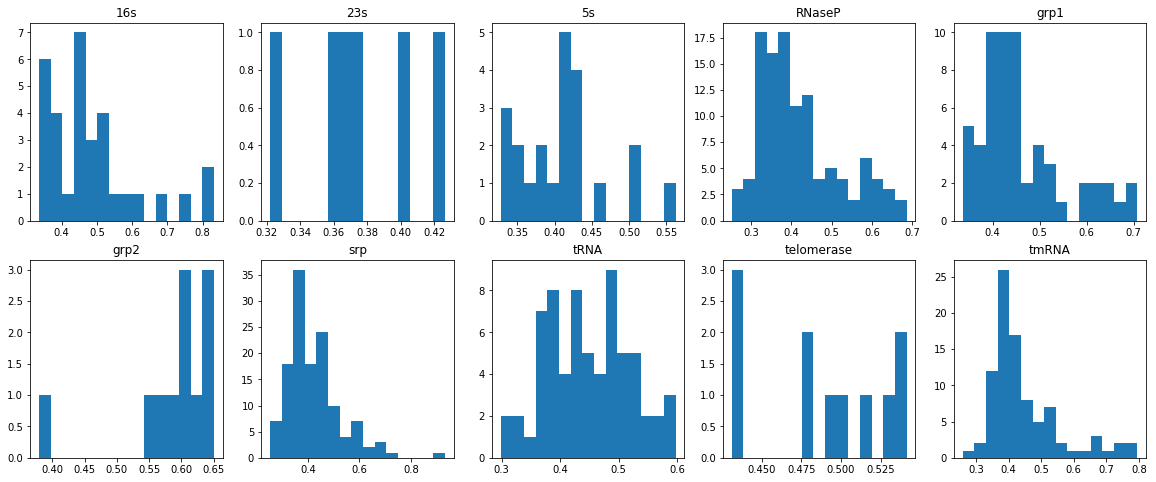

In [24]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
for i in range(5):
    for j in range(2):
        ax[j,i].hist(acc_cate[name_list[j*5+i]],bins =15)
        ax[j,i].set_title(name_list[j*5+i])

In [20]:
name_list

array(['16s', '23s', '5s', 'RNaseP', 'grp1', 'grp2', 'srp', 'tRNA',
       'telomerase', 'tmRNA'],
      dtype='|S32')

In [11]:
category = np.ndarray([540]).astype('S')
for i in range(540):
    category[i] = name[i].split('_')[0]
name_list = np.unique(category,)
acc_cate = {}
for j in range(10):
    acc_cate[name_list[j]] = []
    for i in range(540):
        if category[i] ==name_list[j]:
            acc_cate[name_list[j]].append(acc[i])
table = pd.DataFrame([10])
for i in range(10):
    table[i] =  sum(acc_cate[name_list[i]])/len(acc_cate[name_list[i]])
table = table.T
table = table.set_index(name_list)
table.columns = ['2d_model']
table

,2d_model
16s,0.489486
23s,0.374352
5s,0.410772
RNaseP,0.419563
grp1,0.461456
grp2,0.588972
srp,0.425745
tRNA,0.447959
telomerase,0.488881
tmRNA,0.445325


In [21]:
for i in range(10):
    table[i] =  sum(acc_cate[name_list[i]])/len(acc_cate[name_list[i]])
table = table.T
table = table.set_index(name_list)
table.columns = ['2d_model']
table['2d_model_restrict'] = np.array(pd.read_csv('known/accuracy/acc_1.30_3')['2d_model'])
table['dense'] = ['0.597','0.684','0.628','0.634','0.587','0.524','0.578','0.563','0.555','0.602']
table = table.round(3)
table.to_csv('known/accuracy/'+save_path)

In [22]:
table.round(3)

,2d_model,2d_model_restrict,dense
16s,0.461,0.532,0.597
23s,0.343,0.419,0.684
5s,0.401,0.445,0.628
RNaseP,0.400,0.442,0.634
grp1,0.455,0.494,0.587
grp2,0.552,0.640,0.524
srp,0.435,0.436,0.578
tRNA,0.447,0.451,0.563
telomerase,0.477,0.516,0.555
tmRNA,0.434,0.471,0.602


In [52]:
predict_result_1 = {}
with h5py.File('known/pictures_540') as f:
    for i in tqdm(range(540)):
        images = f[str(i)][:]
        predict_result_1[i] = model.predict(images)[:,:128]

HBox(children=(IntProgress(value=0, max=540), HTML(value=u'')))

NameError: name 'model_1' is not defined

In [135]:
from Bio import SeqIO
f = h5py.File('known/known.h5')
record_dict = SeqIO.to_dict(SeqIO.parse("known/sequences.fa", "fasta"))
sequences = {}
for i in range(540):
    sequences[i] = record_dict[f['name'][:][i]].seq.tostring()
class Onehot(object):
    def __init__(self, alphabet='ATCG'):
        self.transtable = np.zeros(128, np.int64)
        self.transtable[[ord(a) for a in alphabet]] = range(len(alphabet))
        self.alphabet = np.frombuffer(alphabet, np.int8)
    def encode(self, seq):
        seq_int = self.transtable[np.frombuffer(seq, np.int8)]
        encoded = np.zeros((len(seq), len(self.alphabet)), np.int8)
        encoded[np.r_[:len(seq)], seq_int] = 1
        return encoded
    def decode(self, a):
        return self.alphabet[np.argmax(a, axis=1)].tostring()
onehot = Onehot()



def convert_to_image(seqs_array):
    '''
    input many fragments from the same sequences length*128*4
    return many pictures: length*128*128*16
    '''
    shape = seqs_array.shape[0]
    pictures = np.ndarray([shape,128,128,16])
    for i in range(shape):
        x = seqs_array[i]
        pictures[i] = (np.repeat(x, 4, axis=1)[np.newaxis, :, :]*np.tile(x, 4)[:, np.newaxis, :])
    return pictures

In [58]:
def convert_binary(array):
    shape = array.shape[0]
    new = np.ndarray([shape,shape+128])
    for i in range(shape):
        new[i] = np.concatenate((np.concatenate((np.zeros(i),array[i])),np.zeros(shape-i)))
    return new
matshow(convert_binary(predict_result[3]) - convert_binary(predict_result_1[3]),cmap = cm.RdBu_r)

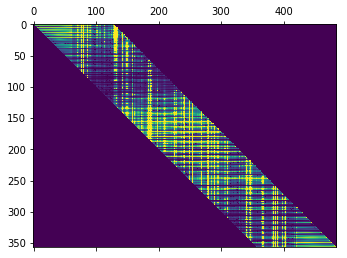

In [158]:
matshow(convert_binary(predict_result[0])) #357

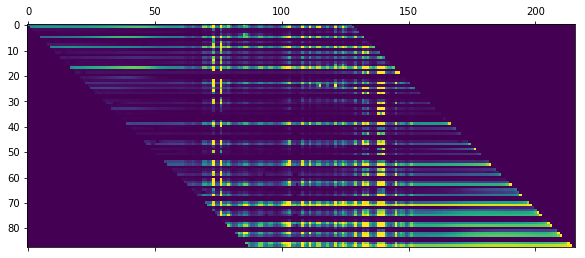

In [159]:
matshow(convert_binary(predict_result[3])) #88

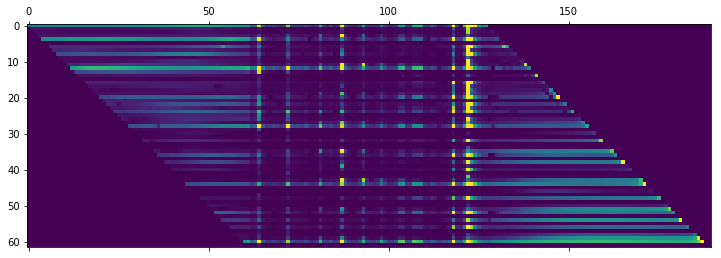

In [160]:
matshow(convert_binary(predict_result[18])) #62

In [119]:
def boxplot(i):
    fig, ax = subplots(figsize=(20, 5))
    sns.boxplot(data = pd.DataFrame(data=convert_binary(predict_result[i])[:,64:-64]), ax=ax,boxprops=dict(alpha=.5),color='g')

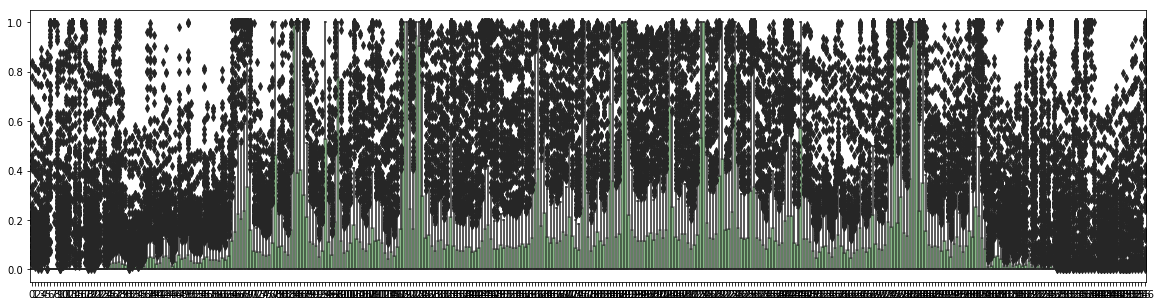

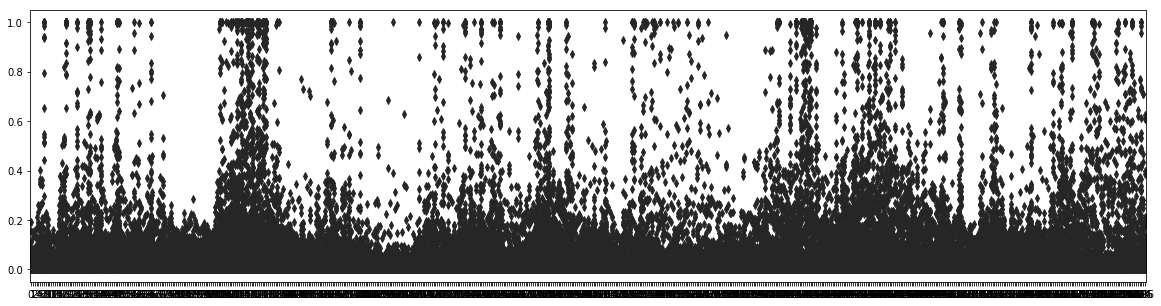

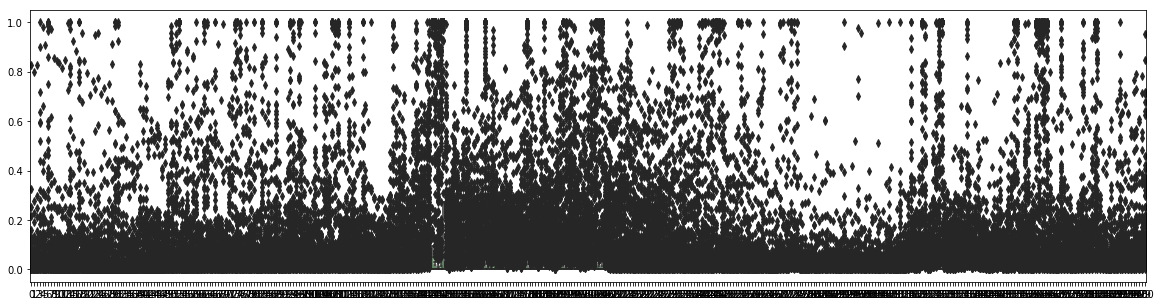

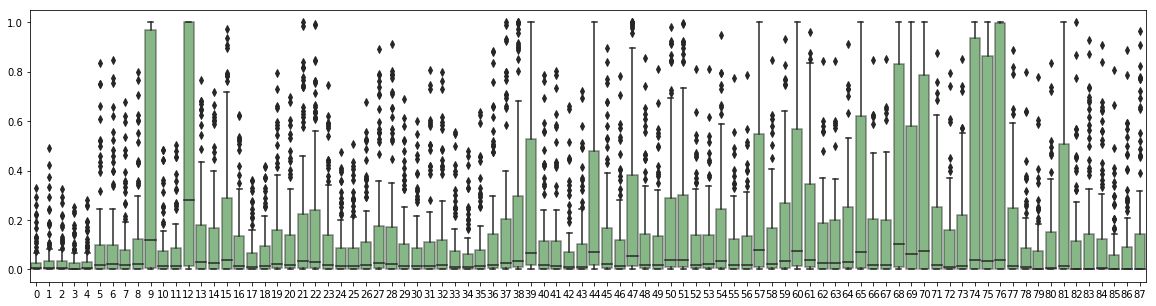

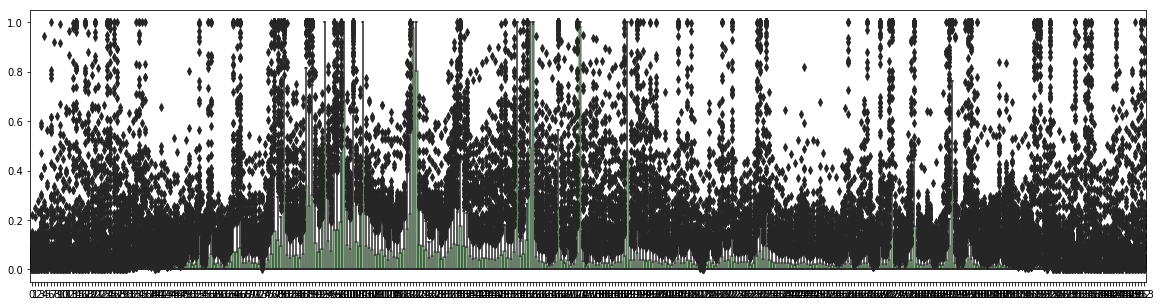

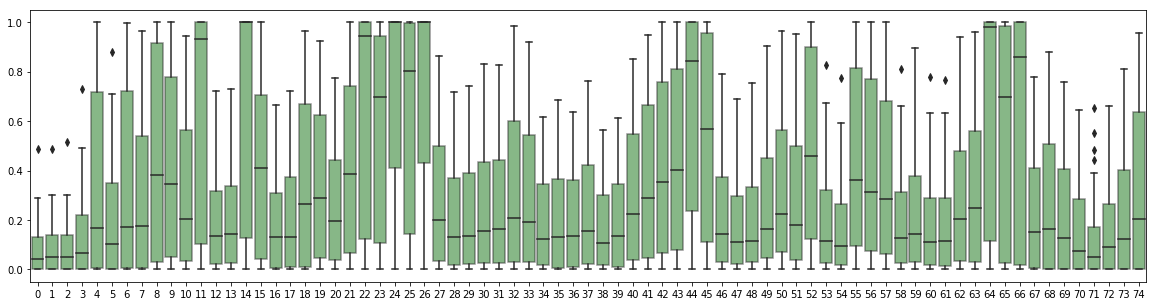

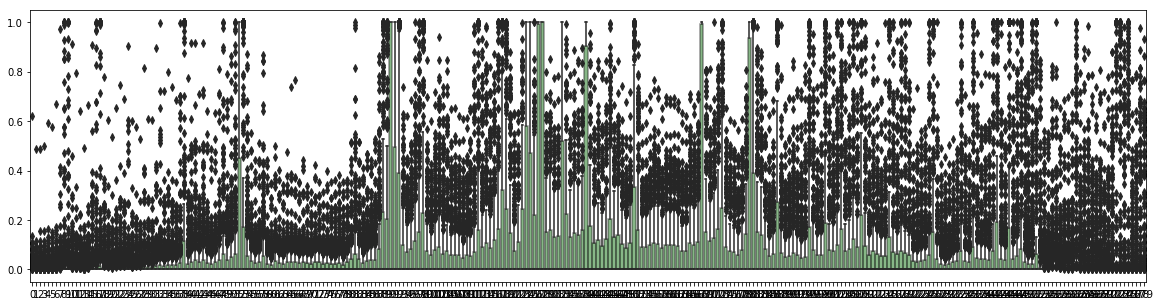

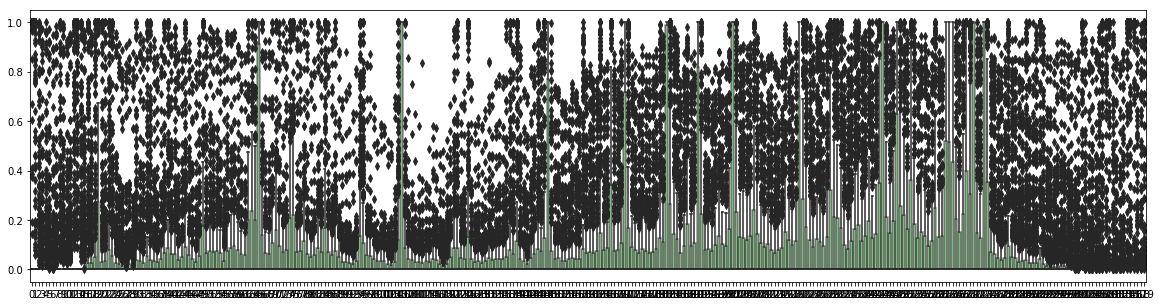

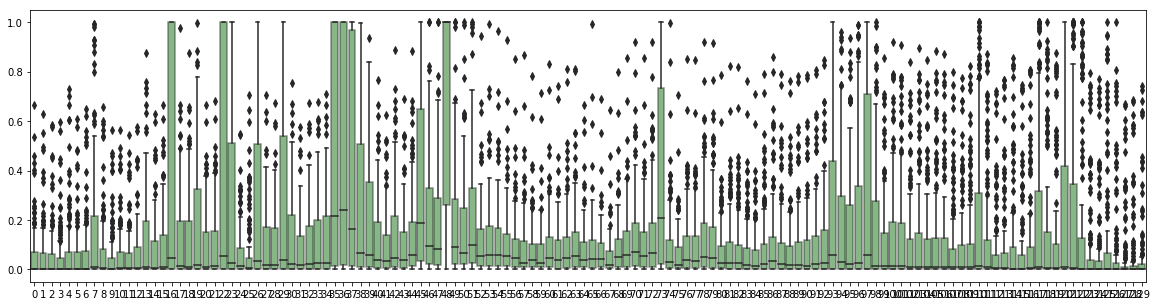

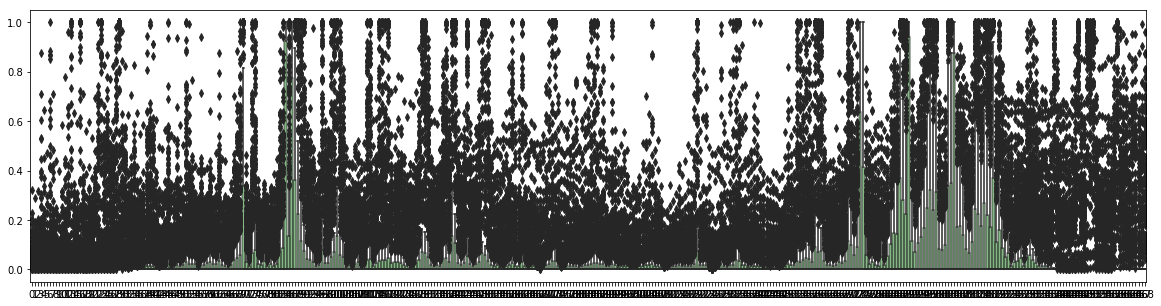

In [121]:
for i in range(10):
    boxplot(i)